# Data Warehouse

The following script loads in data from two sources:
1. AirBnB data from the Washington, D.C. Metro Area [http://insideairbnb.com/get-the-data]
2. Crime data from the Washington, D.C. area [crimecards.dc.gov]

The airbnb data is for the last 4 quarters starting from December 15th 2021 to September 14th 2022. For each of the 4 quarters, we create 4 tables from the AirBnB data:
1. `listings`
2. `neighborhoods` (spelled `neighbourhoods` in the AirBnB website)
3. `reviews`
4. `calendar`

For the crime data, we create **TODO**

### Notes for running this notebook
* This notebook assumes that all source data .csv files are in the same directory as this script
* The September 14th, 2022 `listings.csv` data source included a `source` column that the other `listings.csv` files did not. We chose to drop this column for that quarter because `source` was simply where the data was scraped from and we don't plan on using that
* Order of import matters for `listings.csv` when using read_csv_auto. 11Jun, 14Sep, and 19Mar had a value, 558788119405795275, that couldn't be represented as an INTEGER (32-bit). If you import the December data first, then it defaults to storing this data as a BIGINT (64-bit), which seems to work. Alternatively, alter the column to BIGINT.

## Setup

We are using DuckDB version 0.5.1

In [25]:
import duckdb
import pandas as pd
import json
import os
import gzip
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import geopandas as gpd



In [13]:
con = duckdb.connect(database='ps6.duckdb', read_only=False)

## Add Data
Reference: https://duckdb.org/docs/api/python/overview

### 1. listings.csv

Team question: What was the reason for explicitly specifying the columns and types? Did the auto read csv not bring in the data correctly?

In [82]:

# con.execute('CREATE TABLE listings'
#             '(id BIGINT,'
#             'listing_url VARCHAR,'
#             'scrape_id BIGINT,'
#             'last_scraped DATE,'
#             'source VARCHAR,'
#             'name VARCHAR,'
#             'description VARCHAR,'
#             'neighborhood_overview VARCHAR,'
#             'host_id INTEGER,'
#             'host_url VARCHAR,'
#             'host_name VARCHAR,'
#             'host_since DATE,'
#             'host_location VARCHAR,'
#             'host_about VARCHAR,'
#             'host_response_time VARCHAR,'
#             'host_response_rate VARCHAR,'
#             'host_acceptance_rate VARCHAR,'
#             'host_is_superhost BOOLEAN,'
#             'host_neighbourhood VARCHAR,'
#             'host_listings_count INTEGER,'
#             'host_total_listings_count INTEGER,'
#             'host_verifications VARCHAR,'
#             'host_has_profile_pic BOOLEAN,'
#             'host_identity_verified BOOLEAN,'
#             'neighbourhood_group VARCHAR,'
#             'neighbourhood VARCHAR,'
#             'neighbourhood_cleansed VARCHAR,'
#             'neighbourhood_group_cleansed VARCHAR,'
#             'latitude DOUBLE,'
#             'longitude DOUBLE,'
#             'property_type VARCHAR,'
#             'room_type VARCHAR,'
#             'accommodates INTEGER,'
#             'bathrooms VARCHAR,'
#             'bathrooms_text VARCHAR,'
#             'bedrooms INTEGER,'
#             'beds INTEGER,'
#             'amenities VARCHAR,'
#             'price INTEGER,'
#             'minimum_nights INTEGER,'
#             'maximum_nights INTEGER,'
#             'minimum_minimum_nights INTEGER,'
#             'maximum_minimum_nights INTEGER,'
#             'minimum_maximum_nights INTEGER,'
#             'maximum_maximum_nights INTEGER,'
#             'minimum_nights_avg_ntm DOUBLE,'
#             'maximum_nights_avg_ntm DOUBLE,'
#             'calendar_updated VARCHAR,'
#             'has_availability BOOLEAN,'
#             'availability_30 INTEGER,'
#             'availability_60 INTEGER,'
#             'availability_90 INTEGER,'
#             'availability_365 INTEGER,'
#             'calendar_last_scraped DATE,'
#             'number_of_reviews INTEGER,'
#             'number_of_reviews_ltm INTEGER,'
#             'number_of_reviews_l30d INTEGER,'
#             'first_review DATE,'
#             'last_review DATE,'
#             'review_scores_rating DOUBLE,'
#             'review_scores_accuracy DOUBLE,'
#             'review_scores_cleanliness DOUBLE,'
#             'review_scores_checkin DOUBLE,'
#             'review_scores_communication DOUBLE,'
#             'review_scores_location DOUBLE,'
#             'review_scores_value DOUBLE,'
#             'license VARCHAR,'
#             'instant_bookable BOOLEAN,'            
#             'calculated_host_listings_count INTEGER,'
#             'calculated_host_listings_count_entire_homes INTEGER,'
#             'calculated_host_listings_count_private_rooms INTEGER,'
#             'calculated_host_listings_count_shared_rooms INTEGER,'
#             'reviews_per_month DOUBLE,'
#             'PRIMARY KEY(calendar_last_scraped, id))')

In [83]:
#Original

# con.execute("DROP TABLE IF EXISTS listings")
# con.execute("CREATE TABLE listings AS SELECT * FROM read_csv_auto('14Sep22 listings.csv');")
# con.execute("INSERT INTO listings SELECT * FROM read_csv_auto('11Jun22 listings.csv');")
# con.execute("INSERT INTO listings SELECT * FROM read_csv_auto('15Dec21 listings.csv');")
# con.execute("INSERT INTO listings SELECT * FROM read_csv_auto('19Mar22 listings.csv');")



In [5]:
con.execute('DROP TABLE IF EXISTS all_listings;')
con.execute("CREATE TABLE all_listings AS SELECT * FROM read_csv_auto('14Sep22 listings 2.csv');")
con.execute("ALTER TABLE all_listings DROP source;")
con.execute("INSERT INTO all_listings SELECT * FROM read_csv_auto('11Jun22 listings 2.csv');")
con.execute("INSERT INTO all_listings SELECT * FROM read_csv_auto('15Dec21 listings 2.csv');")
con.execute("INSERT INTO all_listings SELECT * FROM read_csv_auto('19Mar22 listings 2.csv');")


#### Create a view for just the latest listings

The all_listings table includes multiple entries for the same listing. We may want to just deal with one listing for the whole year, taking the latest data. This would weight each listing the same.  

First, we need to determine the latest listing for each listing (e.g. when was the latest data scrape for listing 3686?)

In [6]:
con.execute('drop view if exists last_scraped')
con.execute('create view last_scraped as select id, max(calendar_last_scraped) as last_scraped from all_listings group by id;')

Now, we'll create a view called latest_listings that only takes the latest listing data for each listing.

In [7]:
con.execute('drop view if exists latest_listings')
con.execute('create view latest_listings as select all_listings.* from all_listings inner join last_scraped on all_listings.id = last_scraped.id and all_listings.calendar_last_scraped = last_scraped.last_scraped; ')

How many listings are there compared to the entire data set?

In [8]:
con.execute("select count(id) from latest_listings;")
print(con.fetchall())

[(10560,)]


There were 28076 total rows in the all_listings data.

con.execute("select count(id) from latest_listings;")
print(con.fetchall())

The latest_listings view, which only has one row per listing, has just 10560 rows, less than half of the original data set.

### 2. neighborhood.csv

In [9]:
con.execute('DROP TABLE IF EXISTS neighborhoods;')
con.execute('CREATE TABLE neighborhoods'
            '(neighbourhood_group VARCHAR,'
            'neighbourhood VARCHAR PRIMARY KEY,'
            'type_outer VARCHAR,'
            'feature_type VARCHAR,'
            'geometry_type VARCHAR,'
            'coordinates DOUBLE[][])')

In [10]:
df = pd.read_csv("11Jun22 neighbourhoods.csv")

In [11]:
names = ["11Jun22 neighbourhoods.geojson", "14Sep22 neighbourhoods.geojson", "15Dec21 neighbourhoods.geojson", "19Mar22 neighbourhoods.geojson"]
total = pd.DataFrame()
last = pd.DataFrame(columns=["type_outer", "feature_type", "geometry_type", "coordinates", "neighborhood", "neighborhood group"])
diff = False
for n in names:
    with open(n, 'r') as f:
        data = json.load(f)
    
        row = []
        type_outer = ""
        type_outer = data["type"]
        features = []
        feature_type = ""
        geometry, properties = [], []
        for y in range(0, len(data["features"])):
            features = data["features"][y]
            feature_type = features["type"]
            geometry = features["geometry"]
            properties = features["properties"]
            geometry_type, neigh, neigh_group = "", "", ""
            coords = []
            geometry_type = geometry["type"]
            coords = geometry["coordinates"][0][0]
            neigh = properties["neighbourhood"]
            neigh_group = properties["neighbourhood_group"]
            
            if len(last) == 0:
                row.append([type_outer, feature_type, geometry_type, coords, neigh, neigh_group])
                diff = True
                
            elif list(last[last["neighborhood"] == neigh]["coordinates"])[0] != list(coords):
                lastcoords = list(last[last["neighborhood"] == neigh]["coordinates"])[0]
                diff = True
                row.append([type_outer, feature_type, geometry_type, coords, neigh, neigh_group])
        
        if diff == True:
            last = pd.DataFrame(row, columns=["type_outer", "feature_type", "geometry_type", "coordinates", "neighborhood", "neighborhood group"])
            json_df = pd.DataFrame(row, columns=["type_outer", "feature_type", "geometry_type", "coordinates", "neighborhood", "neighborhood group"])
            diff = False
            
            pd.concat([df, pd.read_csv(n.replace("geojson", "csv"))])
            df.drop_duplicates()
            
            new_df = df.join(json_df.set_index("neighborhood"), on="neighbourhood")
            
            total = pd.concat([total, new_df])

In [12]:
total = total.drop(['neighborhood group'], axis=1)

In [13]:
con.execute("INSERT INTO neighborhoods SELECT * FROM total;")

### 3. reviews.csv

In [14]:
con.execute('DROP TABLE IF EXISTS reviews;')
con.execute('CREATE TABLE reviews'
            '(listing_id BIGINT,'
            'id BIGINT PRIMARY KEY,'
            'date DATE,'
            'reviewer_id INTEGER,'
            'reviewer_name VARCHAR,'
            'comments VARCHAR)')

In [15]:
reviews_df = pd.read_csv('14Sep22 reviews 2.csv')
pd.concat([reviews_df, pd.read_csv('11Jun22 reviews 2.csv')])
pd.concat([reviews_df, pd.read_csv('15Dec21 reviews 2.csv')])
pd.concat([reviews_df, pd.read_csv('19Mar22 reviews 2.csv')])
reviews_df.drop_duplicates(subset=['id'])

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,3571,36234,2010-04-18,81912,Jon,"Don's apartment is comfortable, clean and well..."
1,3571,51518,2010-06-10,112316,David,Don was a great host. He went out of his way t...
2,3571,132238,2010-11-02,255952,Diana,This place was great! Don was extremely helpfu...
3,3571,326887,2011-06-21,637695,Monica,This condo was in a great location for touring...
4,3571,368063,2011-07-12,448224,Florence,"The apartment was very clean, comfortable and ..."
...,...,...,...,...,...,...
321204,705262593266969561,709423398399592317,2022-09-05,464219597,Charlene,"Beautiful apartment, very safe"
321205,705307910480790712,709393953785783433,2022-09-05,43384449,Rainer,Great quiet getaway in DC in residential neigh...
321206,705307910480790712,713759649218625398,2022-09-11,261620474,Ricardo,"Nice and cozy stay, easy to find with self che..."
321207,708911697866238625,713003106344715260,2022-09-10,225974179,Johnny,Very accommodating. Great space with lots of a...


In [16]:
con.execute("INSERT INTO reviews SELECT * FROM reviews_df;")

### 4. calendar.csv

In [17]:
# function to unzip the file for cleaning and rename it with a unique id
def unzipcalendar(file,uniqueId):
    new_file = 'calendar'+uniqueId+'.csv'
    with gzip.open(file, 'r') as f_in, open(new_file, 'wb') as f_out:
      shutil.copyfileobj(f_in, f_out)
    print(new_file)

In [18]:
# cleans the commas out of prices and adjusted_prices column and saves the data as a float back into the csv
def cleanPrices(filename):
        df = pd.read_csv(filename)
        df['price'] = df['price'].str.replace(',', '').astype(float)
        df['adjusted_price'] = df['adjusted_price'].str.replace(',', '').astype(float)
        df.to_csv(filename, encoding='utf-8', index=False)

In [19]:
# function to clean the csv and remove '$' from the price data so it can be imported as int.
# @arg filename (file.csv)
# @arg match (string, e.g. '$', 'text')
def cleancsv(filename, match):
    original_file = filename
    temp_file = "temp.csv"
    
    string_to_delete = [match]
    with open(original_file, "r") as input:
        with open(temp_file, "w") as output:
            for line in input:
                for word in string_to_delete:
                    line = line.replace(word, "")
                output.write(line)
    os.replace('temp.csv', filename)
    cleanPrices(filename)
    print(filename, ' cleaned')

Unzipping and cleaning the files before we import into duckdb

In [20]:
unzipcalendar('15Dec21 calendar.csv.gz',"12_2021")
unzipcalendar('19Mar22 calendar.csv.gz',"03_2022")
unzipcalendar('11Jun22 calendar.csv.gz',"06_2022")
unzipcalendar('14Sep22 calendar.csv.gz',"09_2022")

calendar12_2021.csv
calendar03_2022.csv
calendar06_2022.csv
calendar09_2022.csv


In [21]:
cleancsv('calendar12_2021.csv','$')
cleancsv('calendar03_2022.csv','$')
cleancsv('calendar06_2022.csv','$')
cleancsv('calendar09_2022.csv','$')

calendar12_2021.csv  cleaned
calendar03_2022.csv  cleaned
calendar06_2022.csv  cleaned
calendar09_2022.csv  cleaned


### Import csv into duckdb

In [22]:
con.execute('CREATE OR REPLACE TABLE calendar'
            '(listing_id BIGINT,'
            'date DATE,'
            'available VARCHAR,'
            'price INTEGER,'
            'adjusted_price INTEGER,'
            'minimum_nights INTEGER,'
            'maximum_nights INTEGER);')
con.execute("COPY calendar FROM 'calendar12_2021.csv' (AUTO_DETECT TRUE);")

In [23]:
con.execute("INSERT INTO calendar SELECT * FROM read_csv('calendar09_2022.csv', delim=',', header=True, columns={'listing_id': 'BIGINT', 'date': 'DATE', 'available': 'VARCHAR', 'price': 'INTEGER', 'adjusted_price': 'INTEGER', 'minimum_nights': 'INTEGER', 'maximum_nights': 'INTEGER'});") 

In [24]:
con.execute("INSERT INTO calendar SELECT * FROM read_csv_auto('calendar03_2022.csv');")
con.execute("INSERT INTO calendar SELECT * FROM read_csv_auto('calendar06_2022.csv');")

### 5. crime.csv

In [15]:
con.execute('DROP TABLE IF EXISTS crimes;')


In [105]:

# con.execute('CREATE TABLE crimes'
#             '(neighborhood_cluster VARCHAR,'
#             'census_tract INTEGER,'
#             'offensegroup VARCHAR,'
#             'longitude DOUBLE,'
#             'end_date VARCHAR,' # TODO: should definitely be DATE
#             'offense_text VARCHAR,'
#             'shift VARCHAR,'
#             'yblock DOUBLE,'
#             'district INTEGER,'
#             'year INTEGER,'
#             'ward INTEGER,'
#             'offensekey VARCHAR,'
#             'bid VARCHAR,'
#             'sector VARCHAR,'
#             'ucr_rank INTEGER,'
#             'psa INTEGER,'
#             'block_group VARCHAR,'
#             'voting_precint VARCHAR,'
#             'xblock DOUBLE,'
#             'block VARCHAR,'
#             'start_date VARCHAR,' # TODO: should definitely be DATE
#             'ccn INTEGER,'
#             'offense VARCHAR,'
#             'octo_record_id VARCHAR,'
#             'anc VARCHAR,'
#             'report_dat VARCHAR,' # TODO: should definitely be DATE
#             'method VARCHAR,'
#             'location VARCHAR,' # TODO: should be DOUBLE[][] but also this column is redundant
#             'latitude DOUBLE)')

In [106]:
#con.execute("INSERT INTO crimes SELECT * FROM read_csv('dc-crimes-search-results-V2.csv', dateformat='%m/%d/%Y, %H:%M:%S %p', AUTO_DETECT=TRUE);")

In [16]:
con.execute("CREATE TABLE crimes as SELECT * FROM read_csv('dc-crimes-search-results-V3.csv', AUTO_DETECT=TRUE);")

In [17]:
con.execute("SELECT COUNT(*) FROM crimes")
print(con.fetchall())

[(27611,)]


In [18]:
con.execute("DESCRIBE")
print(con.fetchall())

[('all_listings', ['accommodates', 'amenities', 'availability_30', 'availability_365', 'availability_60', 'availability_90', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'calendar_last_scraped', 'calendar_updated', 'description', 'first_review', 'has_availability', 'host_about', 'host_acceptance_rate', 'host_has_profile_pic', 'host_id', 'host_identity_verified', 'host_is_superhost', 'host_listings_count', 'host_location', 'host_name', 'host_neighbourhood', 'host_picture_url', 'host_response_rate', 'host_response_time', 'host_since', 'host_thumbnail_url', 'host_total_listings_count', 'host_url', 'host_verifications', 'id', 'instant_bookable', 'last_review', 'last_scraped', 'latitude', 'license', 'listing_url', 'longitude', 'maximum_maximum_nights', 'maximum_minimum_nights', 'maximum_nights', 'maximum_nights_

#### Aggregate Crime Table
For each neighborhood, this counts the number of offenses per type.  

Feel free to add to this.

In [19]:
con.execute('drop view if exists neighborhood_crimes')
con.execute('create view neighborhood_crimes as Select neighborhood_name, '
        'count(neighborhood_name) FILTER (WHERE offense = \'homicide\') as homicides, '
        'count(neighborhood_name) FILTER (WHERE offense = \'robbery\') as robberies, '
        'count(neighborhood_name) FILTER (WHERE offense = \'assault w/dangerous weapon\') as assaults, '
        'count(neighborhood_name) FILTER (WHERE offense = \'theft f/auto\') as theft_from_auto, '
        'count(neighborhood_name) FILTER (WHERE offense = \'theft/other\') as other_thefts, '
        'count(neighborhood_name) FILTER (WHERE offense = \'motor vehicle theft\') as vehicle_theft, '
        'count(neighborhood_name) FILTER (WHERE offense = \'burglary\') as burglaries, '
        'count(neighborhood_name) FILTER (WHERE offense = \'sex abuse\') as sex_abuses, '
        'count(neighborhood_name) FILTER (WHERE offense = \'arson\') as arsons,'
        'count(neighborhood_name) as total_crimes '
        'from crimes group by neighborhood_name;')



### Additional Views


#### Full Latest Listings

This joins the latest listings to the neighborhood crime statistics.

In [20]:
# needs to be joined to crime aggregate table
con.execute('drop view if exists full_latest_listings')
con.execute('create view full_latest_listings as select * from latest_listings left join neighborhood_crimes on latest_listings.neighbourhood_cleansed = neighborhood_crimes.neighborhood_name;')

## Close the connection
The duckdb file is locked until now... You'll have to close it to run CLI commands.

In [8]:
con.close()

## EDA ##
### Single Variable EDA ###
### Crime data ##

Let's start with single variable

In [29]:
con.execute('select * from crimes;')
crime_data = con.fetch_df()


### Neighborhood cluster ###
Neighborhood cluster represents which neighbhor hood the crime happened. There are 45 clusters in this column and they can be matched to a specific neighbhor hood. The most frequent one is cluster 25. This value tied close to the neighbor hood name column. This is a categorical variable.

In [34]:
crime_data.NEIGHBORHOOD_CLUSTER.describe()

count          27609
unique            45
top       cluster 25
freq            2070
Name: NEIGHBORHOOD_CLUSTER, dtype: object

In [33]:
crime_data.NEIGHBORHOOD_CLUSTER.value_counts()

cluster 25    2070
cluster 8     2055
cluster 2     1788
cluster 3     1598
cluster 23    1335
cluster 6     1276
cluster 18    1270
cluster 7     1125
cluster 21    1115
cluster 26    1095
cluster 22     996
cluster 39     990
cluster 34     752
cluster 17     747
cluster 1      729
cluster 33     693
cluster 31     667
cluster 27     592
cluster 4      566
cluster 32     561
cluster 9      501
cluster 19     488
cluster 24     452
cluster 38     367
cluster 11     365
cluster 30     359
cluster 15     329
cluster 20     319
cluster 35     315
cluster 5      301
cluster 14     292
cluster 37     266
cluster 28     225
cluster 12     219
cluster 36     207
cluster 10     188
cluster 16     148
cluster 13      91
cluster 45      48
cluster 29      44
cluster 43      32
cluster 40      15
cluster 44       7
cluster 46       7
cluster 41       4
Name: NEIGHBORHOOD_CLUSTER, dtype: int64

### offense group ###
There are two types of offense crime in this variable, Property and violent, so it's a categorical variable. We can see from the summary that majority of the offense is property.

In [41]:
crime_data.offensegroup.value_counts()

property    23567
violent      4044
Name: offensegroup, dtype: int64

### Longtitude ###
This is a pretty straightforward variable. It represents the longtitude of the crime. Longtitude is a continuous numerical data and let's a take a look at the summary of it.

In [42]:
crime_data.LONGITUDE.describe()

count    27611.000000
mean       -77.007869
std          0.034340
min        -77.112316
25%        -77.030787
50%        -77.010666
75%        -76.986919
max        -76.910021
Name: LONGITUDE, dtype: float64

The min here is -77.1123 and max is -76.9100. Since our crime data is based on DC area, so this make perfect sense. Now let's take a look at the distribution of it.

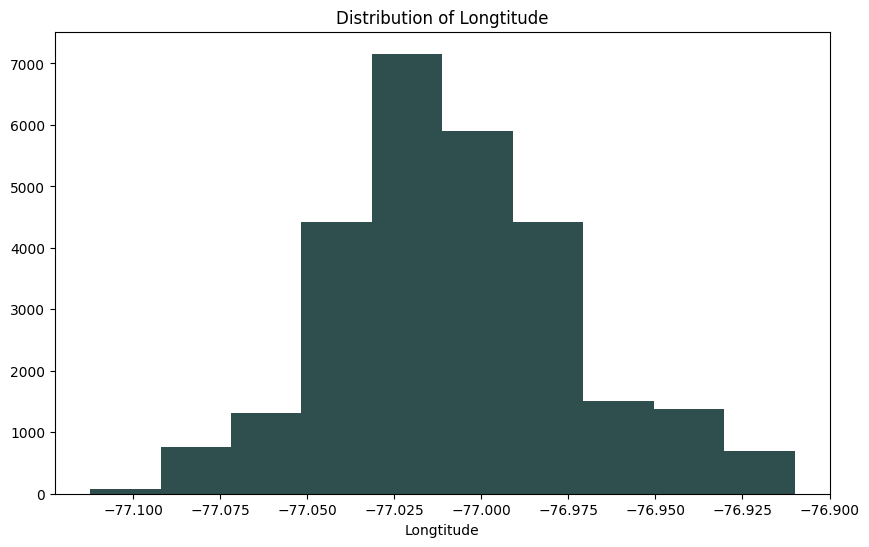

In [63]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(crime_data.LONGITUDE, color="darkslategray")
axes.set_title("Distribution of Longtitude")
axes.set_xlabel("Longtitude")

plt.show()
plt.close()

Here the distribution looks very nearly normal. 50% of the crimes has the longtitude between -77.050 to -76.975.

### end date ###
This variable represents the time and date when the crime end. It's a date type.

In [46]:
crime_data.END_DATE.describe()

count                     25411
unique                    22106
top       5/25/2022, 7:00:00 AM
freq                          7
Name: END_DATE, dtype: object

### offense-text ###
This is another variable to describle the type of crime. It's a categorical variable. Let's take a look at the summary of it.

In [47]:
crime_data['offense-text'].describe()

count           27611
unique              9
top       theft/other
freq            10783
Name: offense-text, dtype: object

In [48]:
crime_data['offense-text'].value_counts()

theft/other                   10783
theft f/auto                   8077
motor vehicle theft            3535
robbery                        2167
assault w/dangerous weapon     1499
burglary                       1168
homicide                        221
sex abuse                       157
arson                             4
Name: offense-text, dtype: int64

We can see there are 9 different types of offsense. Most of them are theft/other and theft/auto which aligned well with our offense group variable.

### Shift ###
Shift means the time range for the crime happened. It's a oridinal variable and there are three values in it, day, midnight, evening. Let's take a look at the summary of it.

In [51]:
crime_data.SHIFT.value_counts()

evening     11109
day         10863
midnight     5639
Name: SHIFT, dtype: int64

We can see that majority of the crimes happened during evening and daytime.

### offense key ##
Offense key is another variable describe the type of crimes. It's a aggregation of offensegroup and offense-text. It's also a categorical variable.

In [52]:
crime_data.offensekey.describe()

count                    27611
unique                       9
top       property|theft/other
freq                     10783
Name: offensekey, dtype: object

In [53]:
crime_data.offensekey.value_counts()

property|theft/other                  10783
property|theft f/auto                  8077
property|motor vehicle theft           3535
violent|robbery                        2167
violent|assault w/dangerous weapon     1499
property|burglary                      1168
violent|homicide                        221
violent|sex abuse                       157
property|arson                            4
Name: offensekey, dtype: int64

We can see that there are 9 unique types and the top 3 are property related crimes which are theft/other, theft/auto and motor vehicle theft.

### start date ###
Similar to end date, this variable represents the time and date when the crime start. It's a date type.

In [54]:
crime_data.START_DATE.describe()

/var/folders/65/6hb0ntlj4v9gxycj2r4v98nm0000gp/T/ipykernel_74200/1243338090.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  crime_data.START_DATE.describe()


count                   27602
unique                    459
top       2021-10-06 00:00:00
freq                      123
first     2010-05-28 00:00:00
last      2022-09-29 00:00:00
Name: START_DATE, dtype: object

### offense ###
This variable describle the actual type of the crime which is similar to the offense-text. It's also a categorical variable.

In [55]:
crime_data.OFFENSE.describe()

count           27611
unique              9
top       theft/other
freq            10783
Name: OFFENSE, dtype: object

In [56]:
crime_data.OFFENSE.value_counts()

theft/other                   10783
theft f/auto                   8077
motor vehicle theft            3535
robbery                        2167
assault w/dangerous weapon     1499
burglary                       1168
homicide                        221
sex abuse                       157
arson                             4
Name: OFFENSE, dtype: int64

Similar to the results above for offense-text, there are 9 types of crimes.

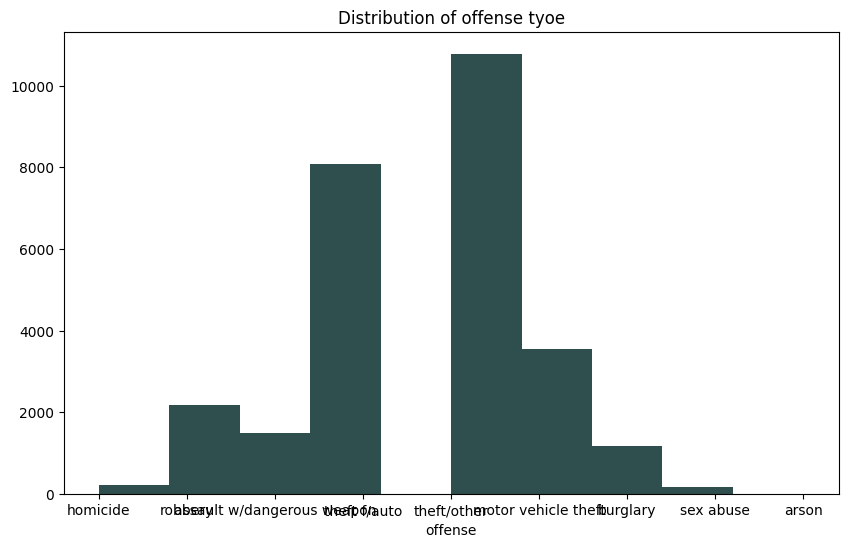

In [62]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(crime_data.OFFENSE, color="darkslategray")
axes.set_title("Distribution of offense tyoe")
axes.set_xlabel("offense")

plt.show()
plt.close()

### Method ###
Method is the variable to describle how the crime was commited. It's a categorical variable. Let's take a look at the summary of it.

In [58]:
crime_data.METHOD.describe()

count      27611
unique         3
top       others
freq       24756
Name: METHOD, dtype: object

In [59]:
crime_data.METHOD.value_counts()

others    24756
gun        2333
knife       522
Name: METHOD, dtype: int64

We can see there are 3 methods in it, others, gun and knife. Most of them are others. 

### Latitude ###
Similar to Longtitude, This is a pretty straightforward variable. It represents the Latitude of the crime. Latitude is a continuous numerical data and let's a take a look at the summary of it.

In [60]:
crime_data.LATITUDE.describe()

count    27611.000000
mean        38.907542
std          0.029605
min         38.814659
25%         38.894325
50%         38.907235
75%         38.923862
max         38.994901
Name: LATITUDE, dtype: float64

The min here is 38.8147 and max is 38.9949. Since our crime data is based on DC area, so this make perfect sense. Now let's take a look at the distribution of it.

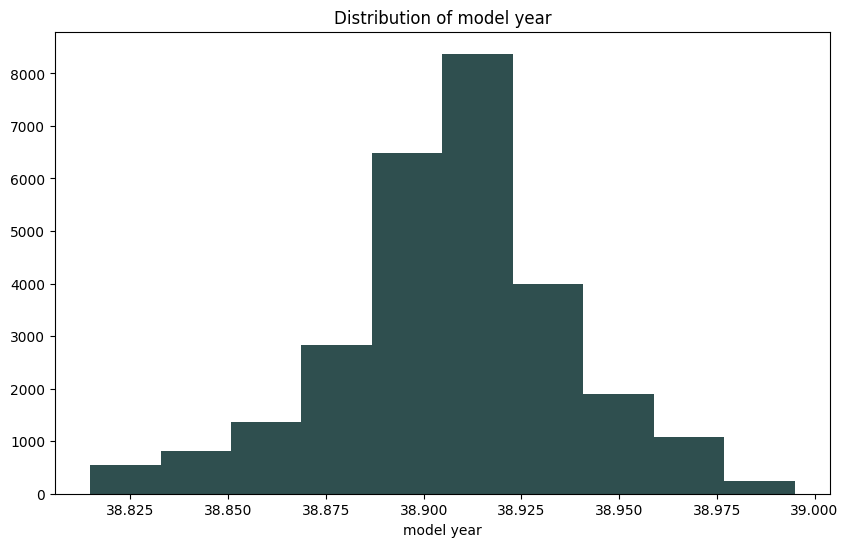

In [61]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(crime_data.LATITUDE, color="darkslategray")
axes.set_title("Distribution of model year")
axes.set_xlabel("model year")

plt.show()
plt.close()

Here the distribution looks very nearly normal. 50% of the longtitude has the latitude between 38.875 to 38.925.

### Neighborhood name ###
This is a new variable we added to the dataset. This is the actual name for the neighborhood cluster. Let's take a look at the summary.

In [64]:
crime_data.NEIGHBORHOOD_NAME.describe()

count                                         27611
unique                                           46
top       Union Station, Stanton Park, Kingman Park
freq                                           2070
Name: NEIGHBORHOOD_NAME, dtype: object

In [65]:
crime_data.NEIGHBORHOOD_NAME.value_counts()

Union Station, Stanton Park, Kingman Park                                                            2070
Downtown, Chinatown, Penn Quarters, Mount Vernon Square, North Capitol Street                        2055
Columbia Heights, Mt. Pleasant, Pleasant Plains, Park View                                           1788
Howard University, Le Droit Park, Cardozo/Shaw                                                       1598
Ivy City, Arboretum, Trinidad, Carver Langston                                                       1335
Dupont Circle, Connecticut Avenue/K Street                                                           1276
Brightwood Park, Crestwood, Petworth                                                                 1270
Shaw, Logan Circle                                                                                   1125
Edgewood, Bloomingdale, Truxton Circle, Eckington                                                    1115
Capitol Hill, Lincoln Park                    

We can see that the downtown area, union station and columbia heights area seems like pretty dangerous. They are the most crimes happened in the Washington D.C. 

## Crimes by neighborhood ##

In [27]:
crime_gdf = gpd.GeoDataFrame(
    crime_data, geometry=gpd.points_from_xy(crime_data.LONGITUDE, crime_data.LATITUDE))

In [ ]:
import geopandas as gpd
from shapely.geometry import Polygon

p_list = []
for p in neighborhoods.coordinates:
  p_list.append(Polygon(p))

neighborhoods_gpd = gpd.GeoDataFrame(neighborhoods, crs='epsg:4326', geometry=p_list)       

neighborhoods_gpd['rep_point'] = neighborhoods_gpd['geometry'].apply(lambda x: x.representative_point().coords[:])
neighborhoods_gpd['rep_point'] = [coords[0] for coords in neighborhoods_gpd['rep_point']]

neighborhoods_gpd['alpha_index'] = list(range(1,len(neighborhoods_gpd.neighbourhood)+1))

neighborhoods_gpd.info()

KeyError: 'rep_point'

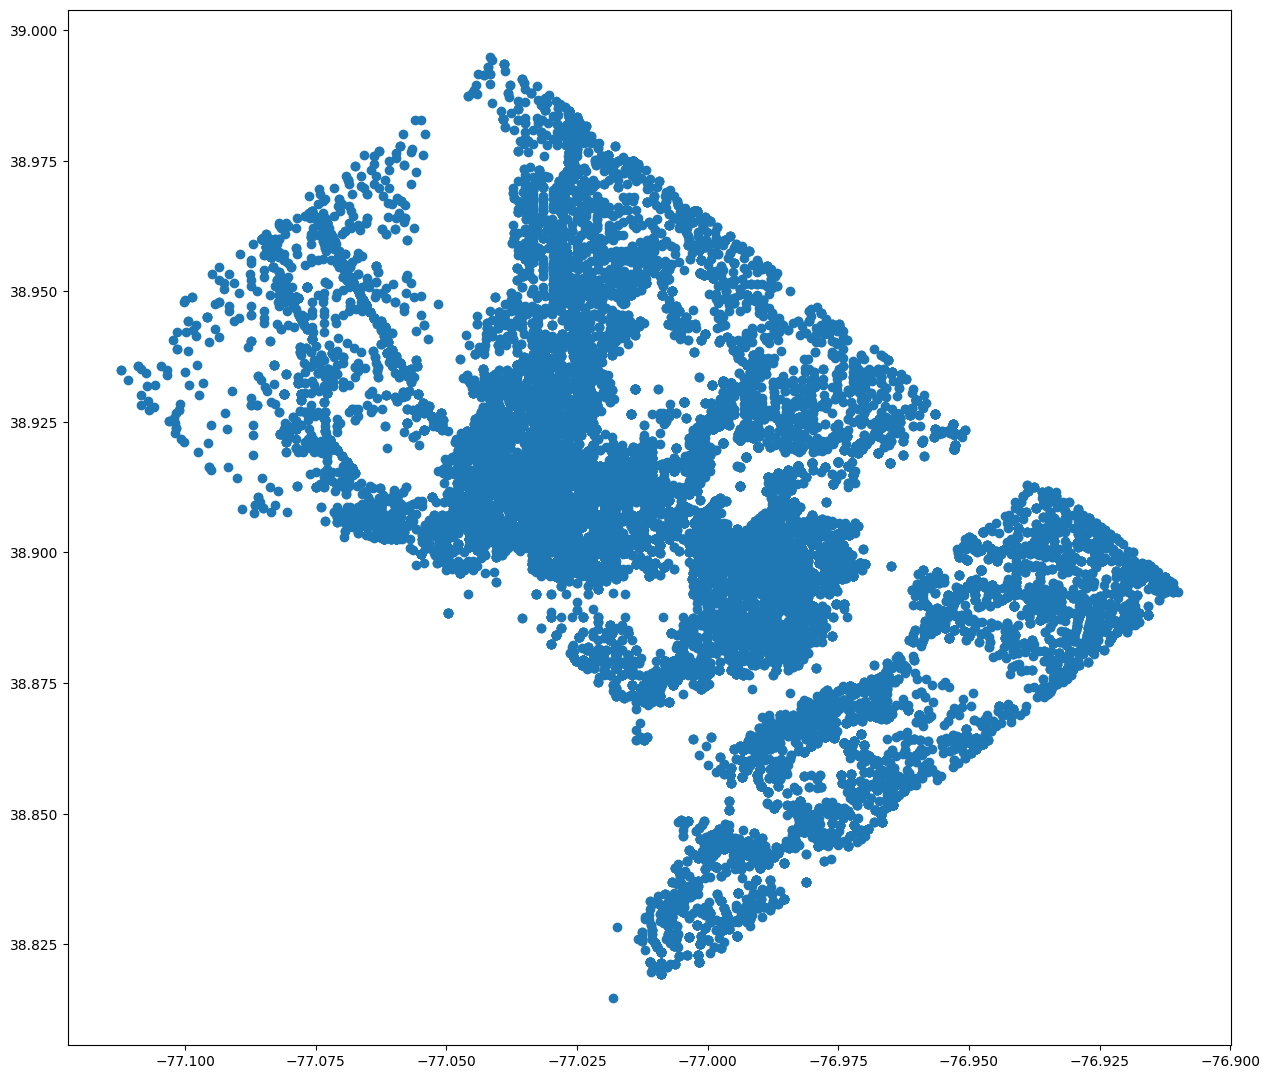

In [30]:
fig,ax = plt.subplots(figsize = (15,15))
base = crime_gdf.plot(ax=ax)
for idx, row in crime_gdf.iterrows():
    plt.annotate(row['column00'], xy=row['rep_point'],
                 horizontalalignment='center')
    
crime_gdf.geometry.plot(ax=base, marker='o', color='red', markersize=5);
    
plt.show()

### Pairwise EDA ###

### Reviews VS Crime ###

We are trying to analyze the relationship between the criminal data and reviews data. Given that reviews dataset only include the review id, reviewer id and comments. It will be hard to quantify them. We will focus on the review scores and total reviews.

We are curious to see if the total crimes happened in a specific neighborhood has any relationships with the review score and total reviews for the airbnb listings in that neighborhood.

There is one specific review for the airbnb is called review_scores_location, we will get the average value for this score for each neighborhood and together combined with the total crimes for the neighborhood.

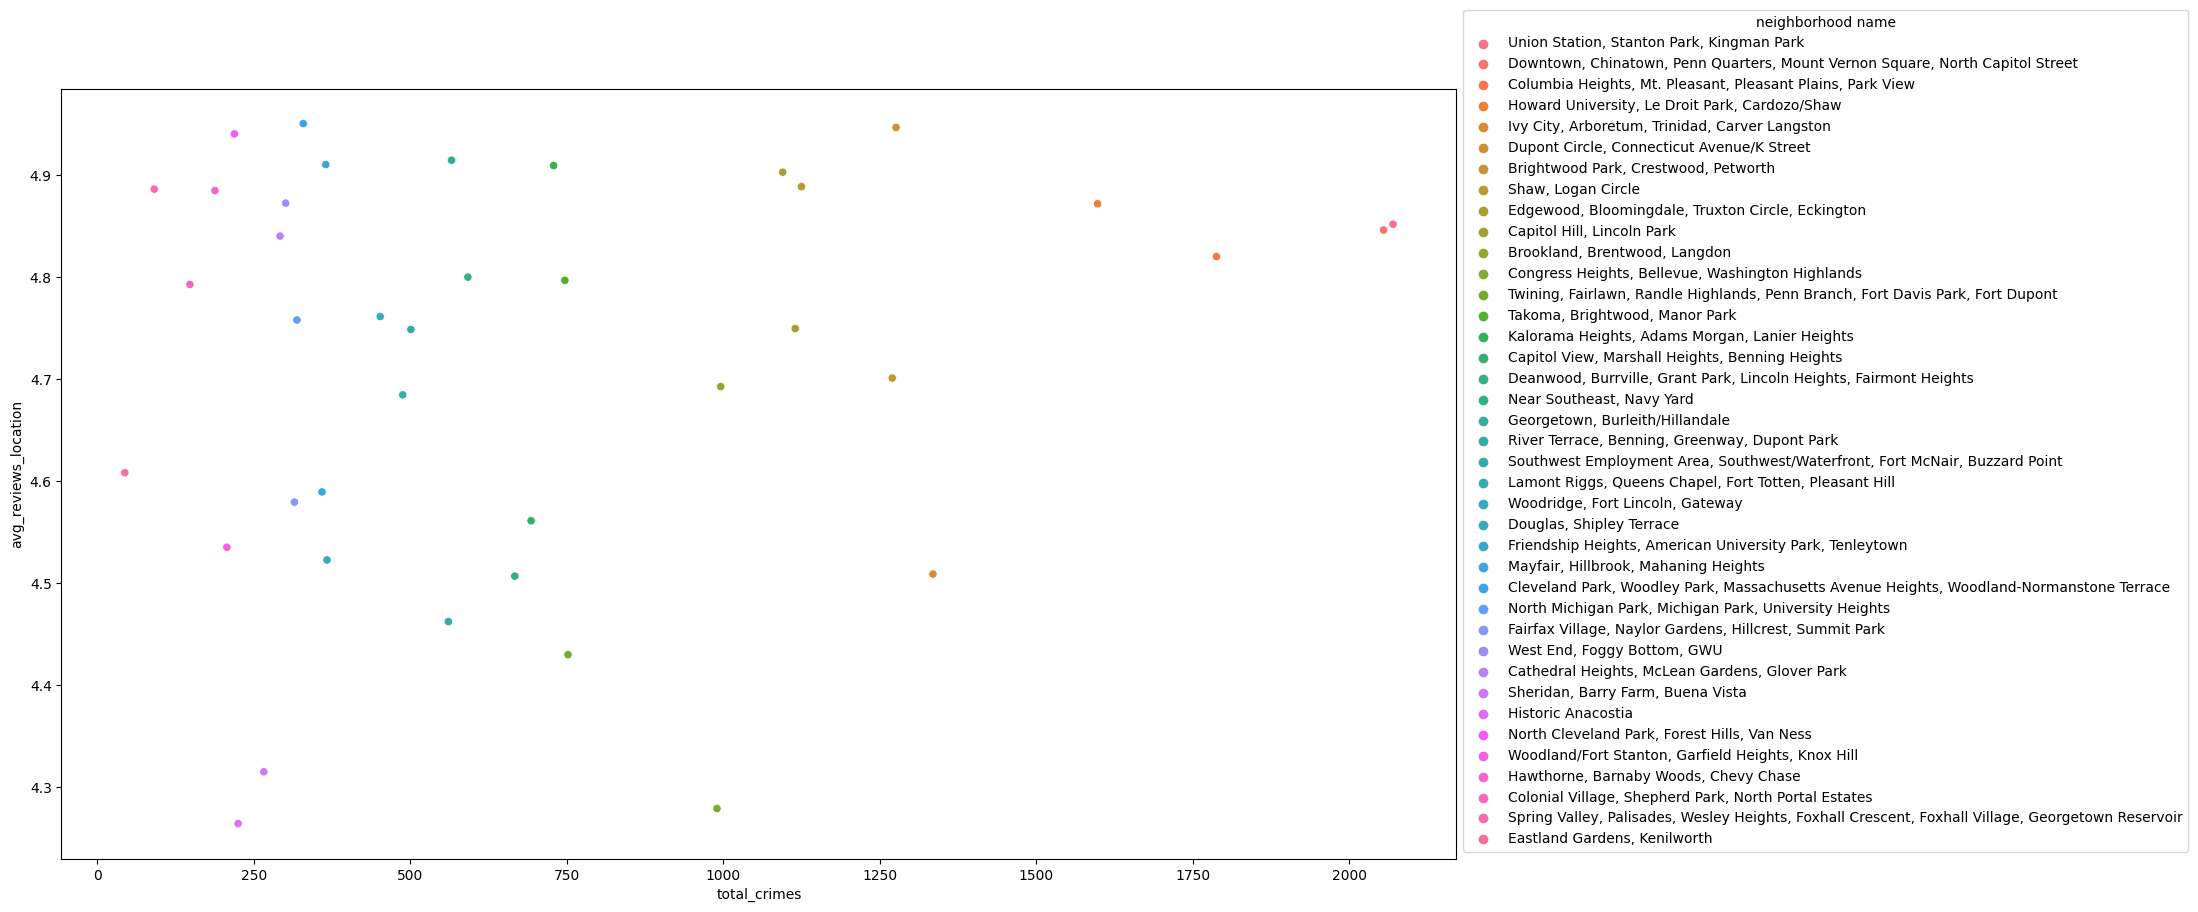

In [100]:
crime_results = con.execute("""
select 
neighborhood_name as neighborhood, count(column00) as total_crimes 
from crimes 
group by neighborhood_name 
order by total_crimes desc;""").df()

location_review = con.execute("""
select neighbourhood_cleansed as neighborhood, avg(review_scores_location) as avg_reviews_location 
from all_listings 
group by neighbourhood_cleansed
order by avg_reviews_location desc;
""").df()

crime_review = pd.merge(crime_results, location_review, on='neighborhood')

figure = plt.figure(figsize=(18, 10))
sns.scatterplot(x=crime_review.total_crimes, 
y=crime_review.avg_reviews_location, 
hue=crime_review.neighborhood)
plt.legend(bbox_to_anchor=(1, 0),loc="lower left", title="neighborhood name")

We can see from the figure that it seems like there is no strong relationship between the average location review scores with the total crimes. The neighborhood with most crimes is Union station, stanton Park, Kingman Park has a fairly high average location review scores. The neighborhood with the lowest location review scores don't have that many crimes happened.

What about the overall scores? maybe there is a relationship between them.

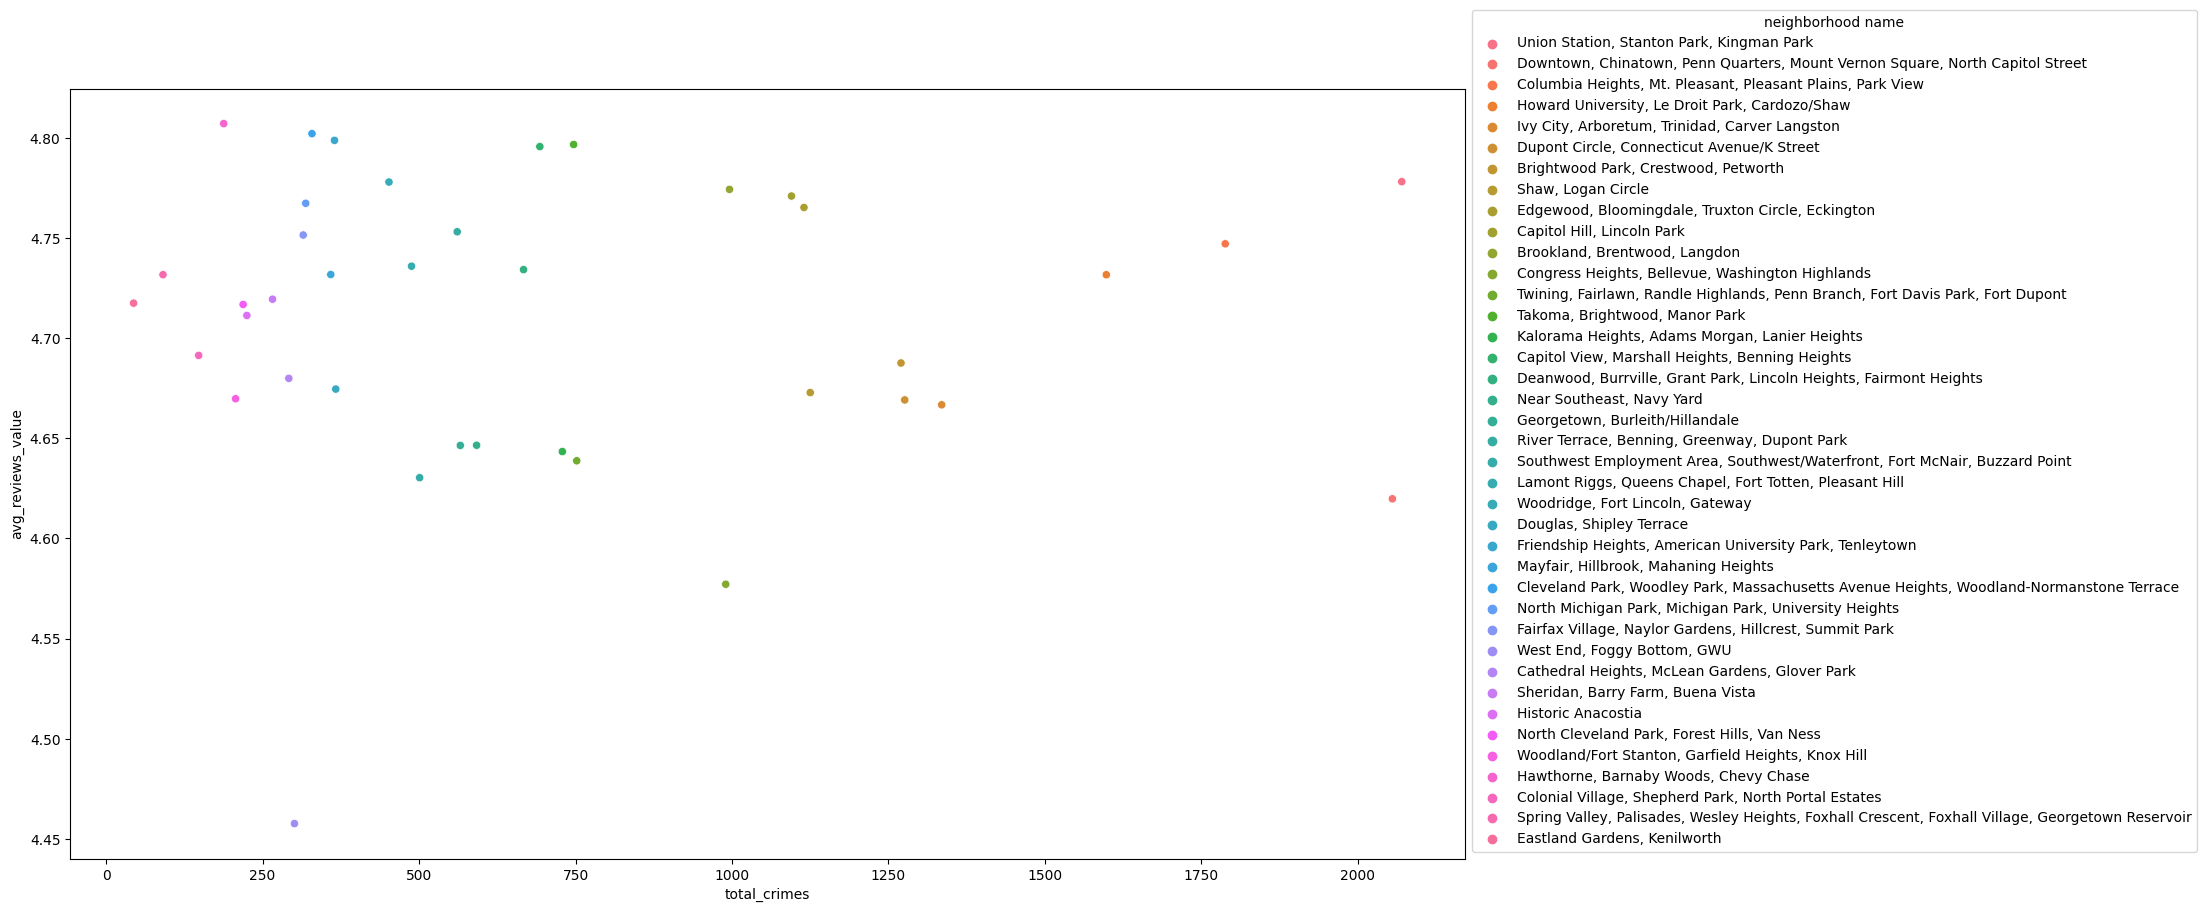

In [102]:
total_review = con.execute("""
select neighbourhood_cleansed as neighborhood, avg(review_scores_value) as avg_reviews_value 
from all_listings 
group by neighbourhood_cleansed
order by avg_reviews_value desc;
""").df()

crime_review = pd.merge(crime_results, total_review, on='neighborhood')

figure = plt.figure(figsize=(18, 10))
sns.scatterplot(x=crime_review.total_crimes, 
y=crime_review.avg_reviews_value, 
hue=crime_review.neighborhood)
plt.legend(bbox_to_anchor=(1, 0),loc="lower left", title="neighborhood name")

We still don't see a strong relationship with them. The neighborhood with less crimes does not have a very high rating score.

Let's check the cleanliness score and see if this has any relationship with the crimes.

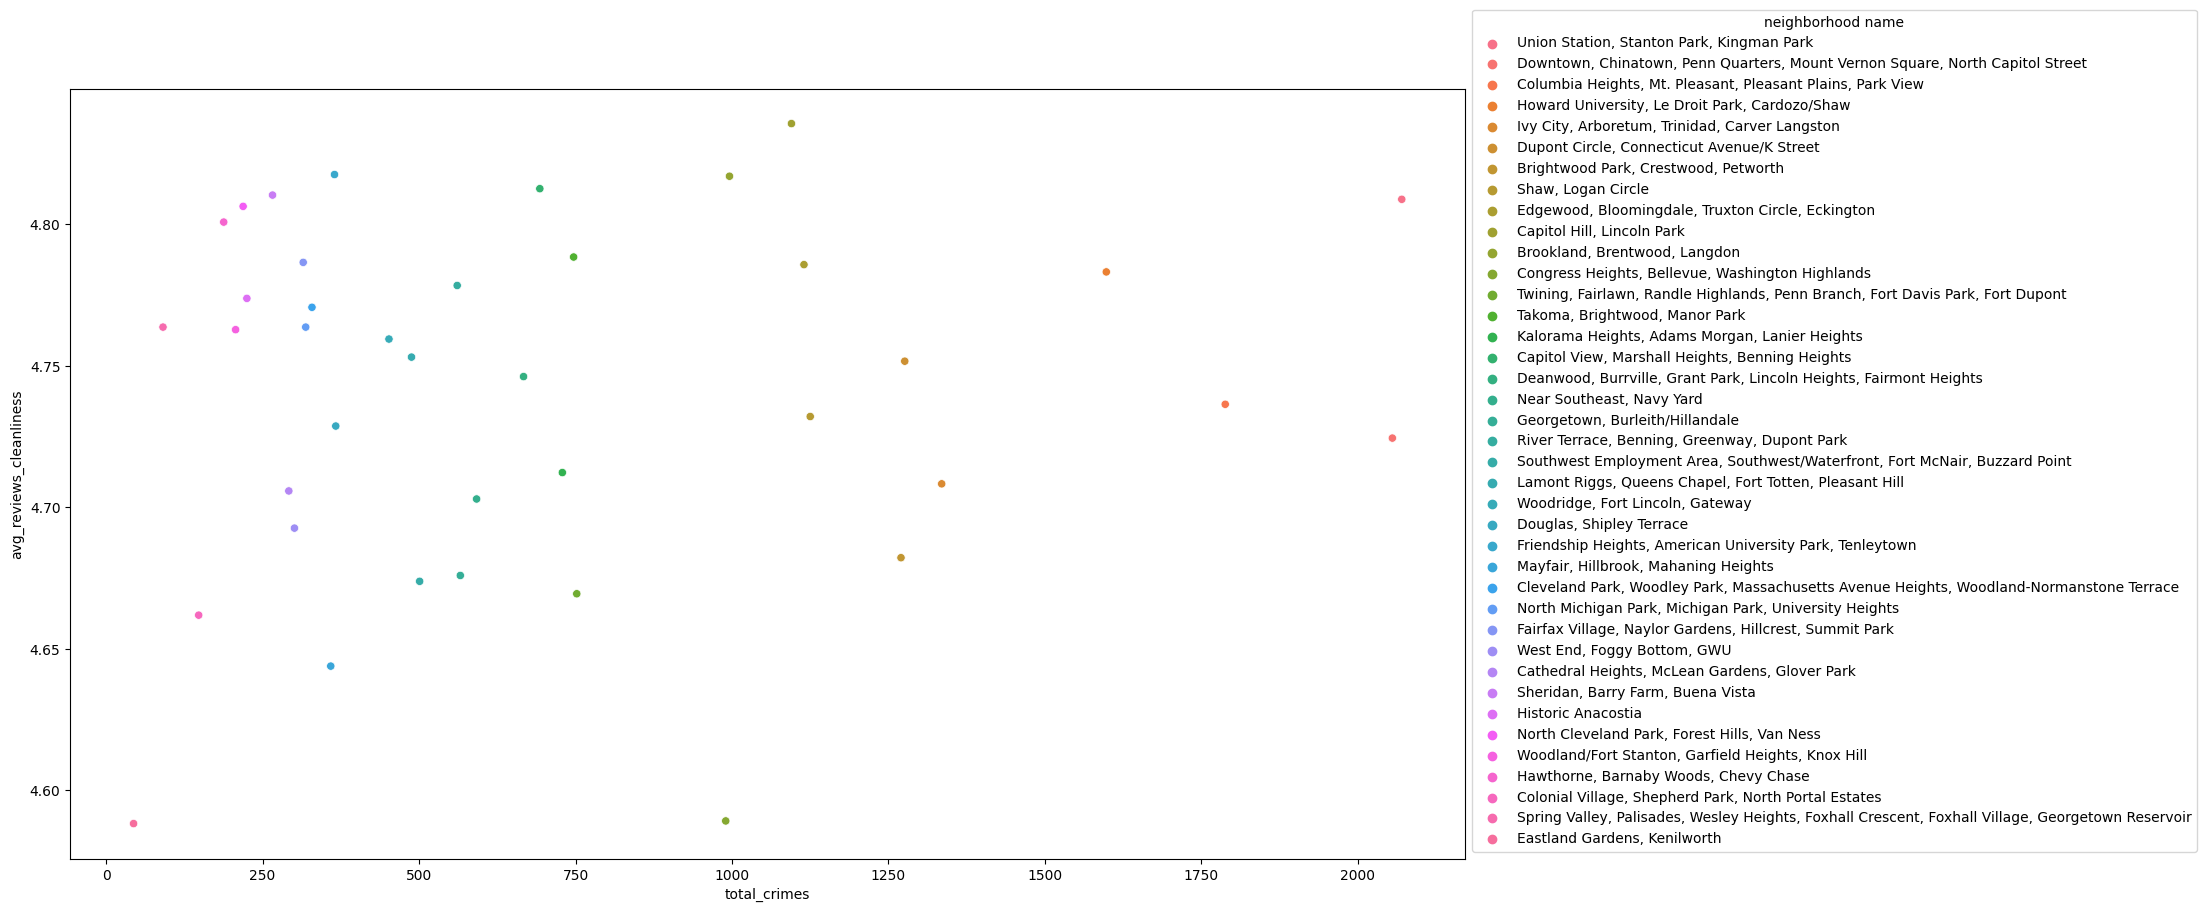

In [105]:
cleanliness_review = con.execute("""
select neighbourhood_cleansed as neighborhood, avg(review_scores_cleanliness) as avg_reviews_cleanliness 
from all_listings 
group by neighbourhood_cleansed
order by avg_reviews_cleanliness desc;
""").df()

crime_review = pd.merge(crime_results, cleanliness_review, on='neighborhood')

figure = plt.figure(figsize=(18, 10))
sns.scatterplot(x=crime_review.total_crimes, 
y=crime_review.avg_reviews_cleanliness, 
hue=crime_review.neighborhood)
plt.legend(bbox_to_anchor=(1, 0),loc="lower left", title="neighborhood name")

It seems like there is still no strong relationship between those two variables.

Let's take a look at the review score rating and see if there are any relationship with the total crimes.

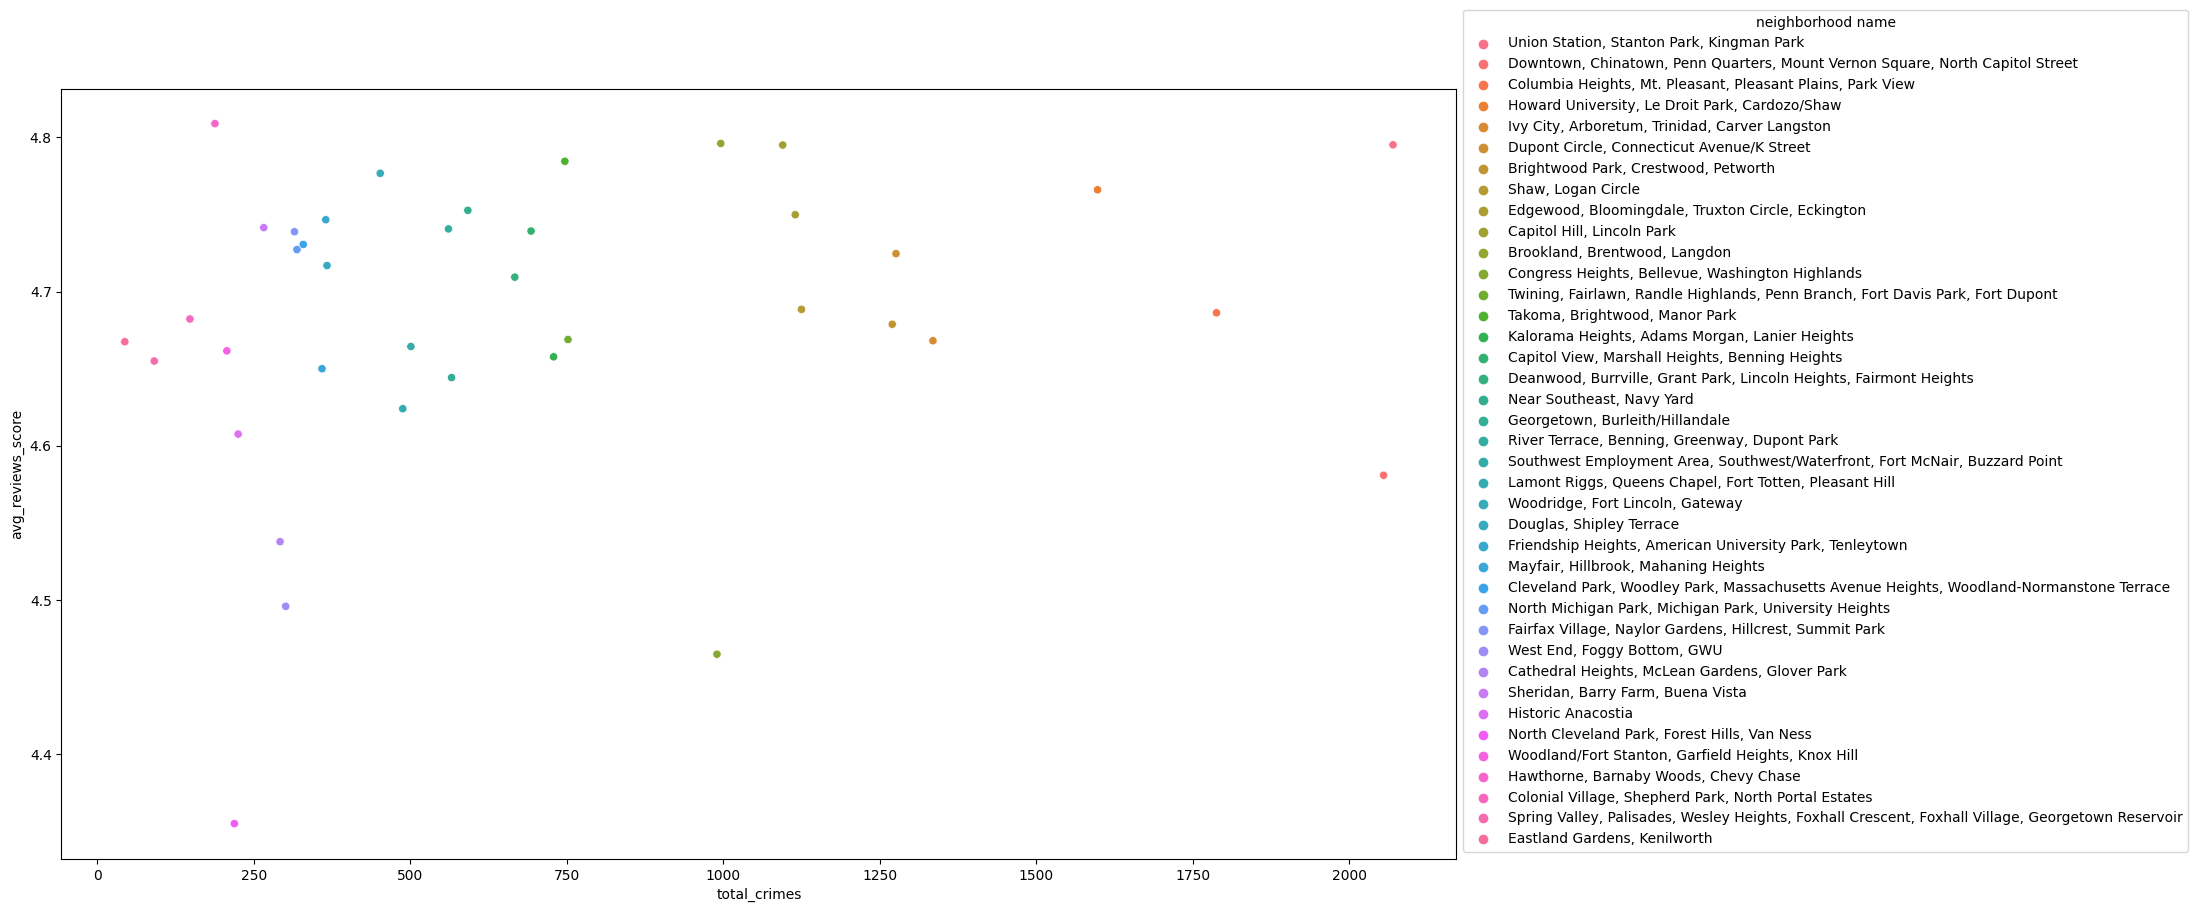

In [110]:
score_review = con.execute("""
select neighbourhood_cleansed as neighborhood, avg(review_scores_rating) as avg_reviews_score
from all_listings 
group by neighbourhood_cleansed
order by avg_reviews_score desc;
""").df()

crime_review = pd.merge(crime_results, score_review, on='neighborhood')

figure = plt.figure(figsize=(18, 10))
sns.scatterplot(x=crime_review.total_crimes, 
y=crime_review.avg_reviews_score, 
hue=crime_review.neighborhood)
plt.legend(bbox_to_anchor=(1, 0),loc="lower left", title="neighborhood name")

similar to the previous results, we don't see a strong trending between the score rating and total crimes for each neighborhood.

Let's now take a look at the communication score.

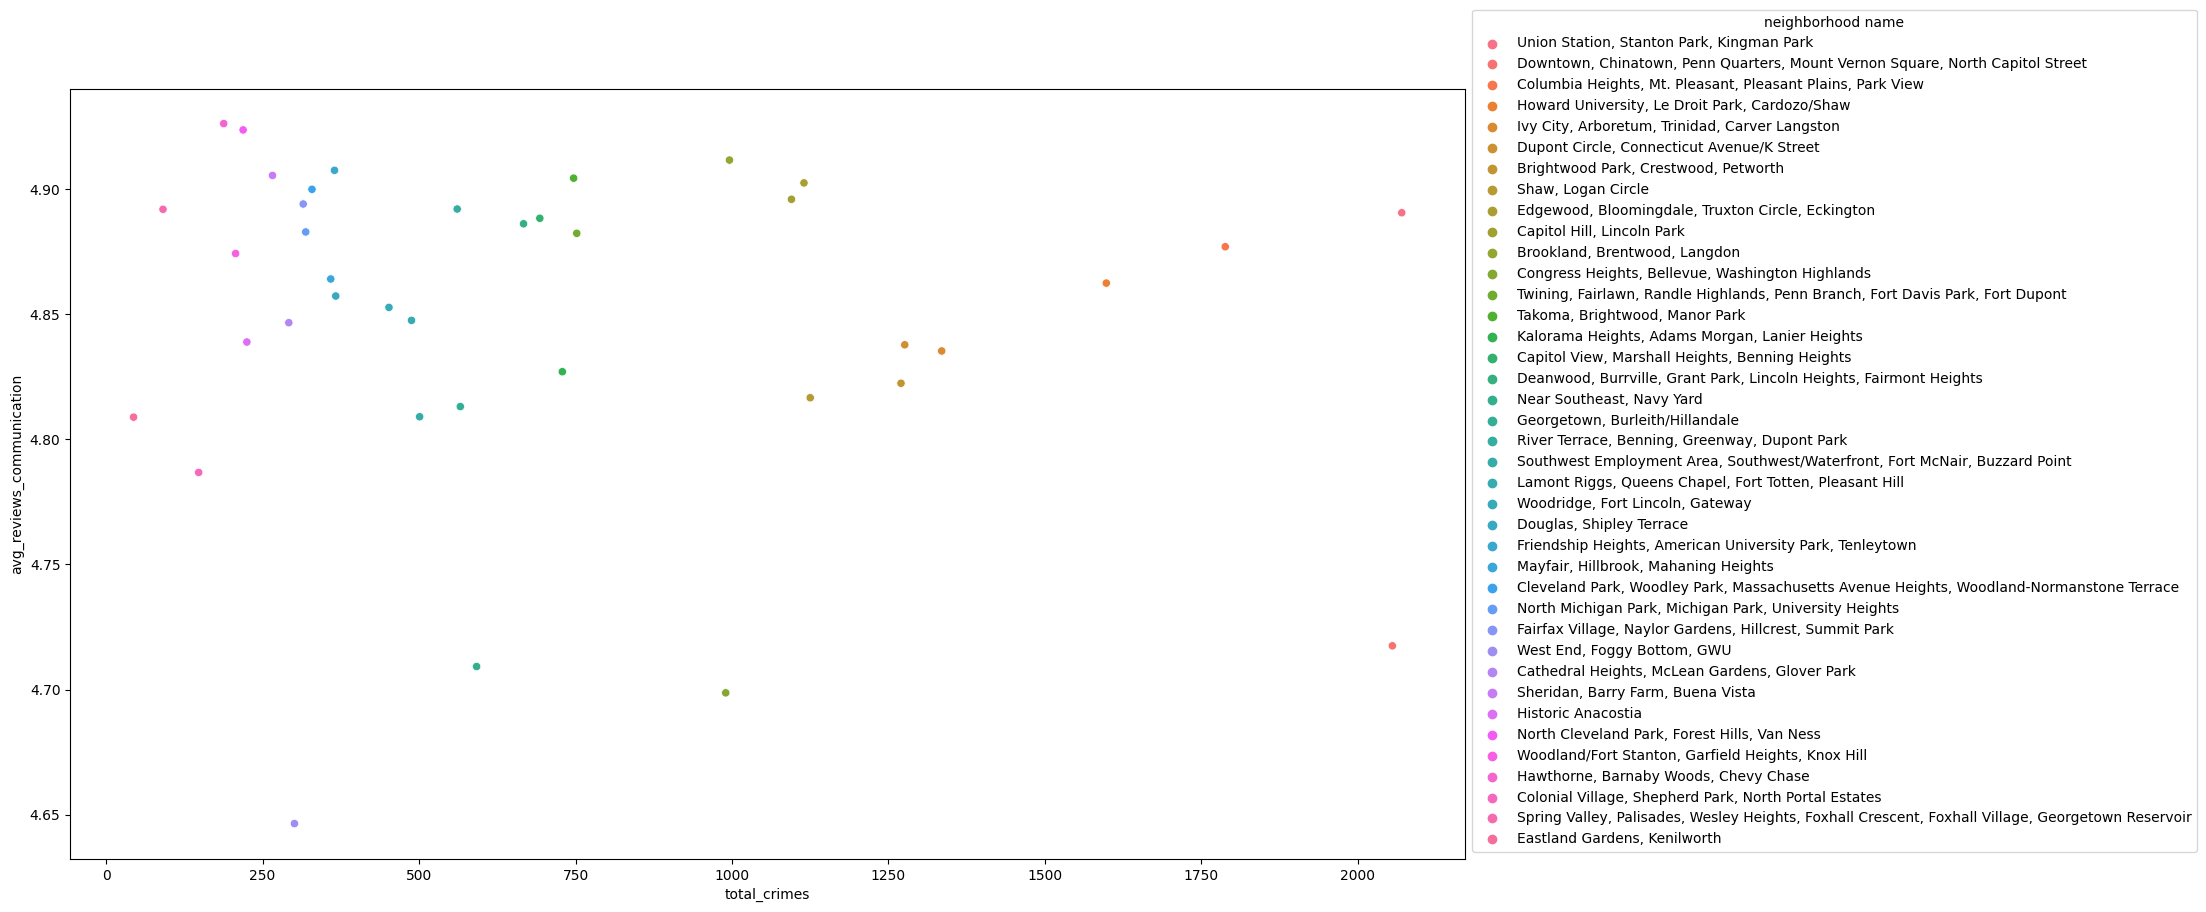

In [112]:
communication_review = con.execute("""
select neighbourhood_cleansed as neighborhood, avg(review_scores_communication) as avg_reviews_communication
from all_listings 
group by neighbourhood_cleansed
order by avg_reviews_communication desc;
""").df()

crime_review = pd.merge(crime_results, communication_review, on='neighborhood')

figure = plt.figure(figsize=(18, 10))
sns.scatterplot(x=crime_review.total_crimes, 
y=crime_review.avg_reviews_communication, 
hue=crime_review.neighborhood)
plt.legend(bbox_to_anchor=(1, 0),loc="lower left", title="neighborhood name")

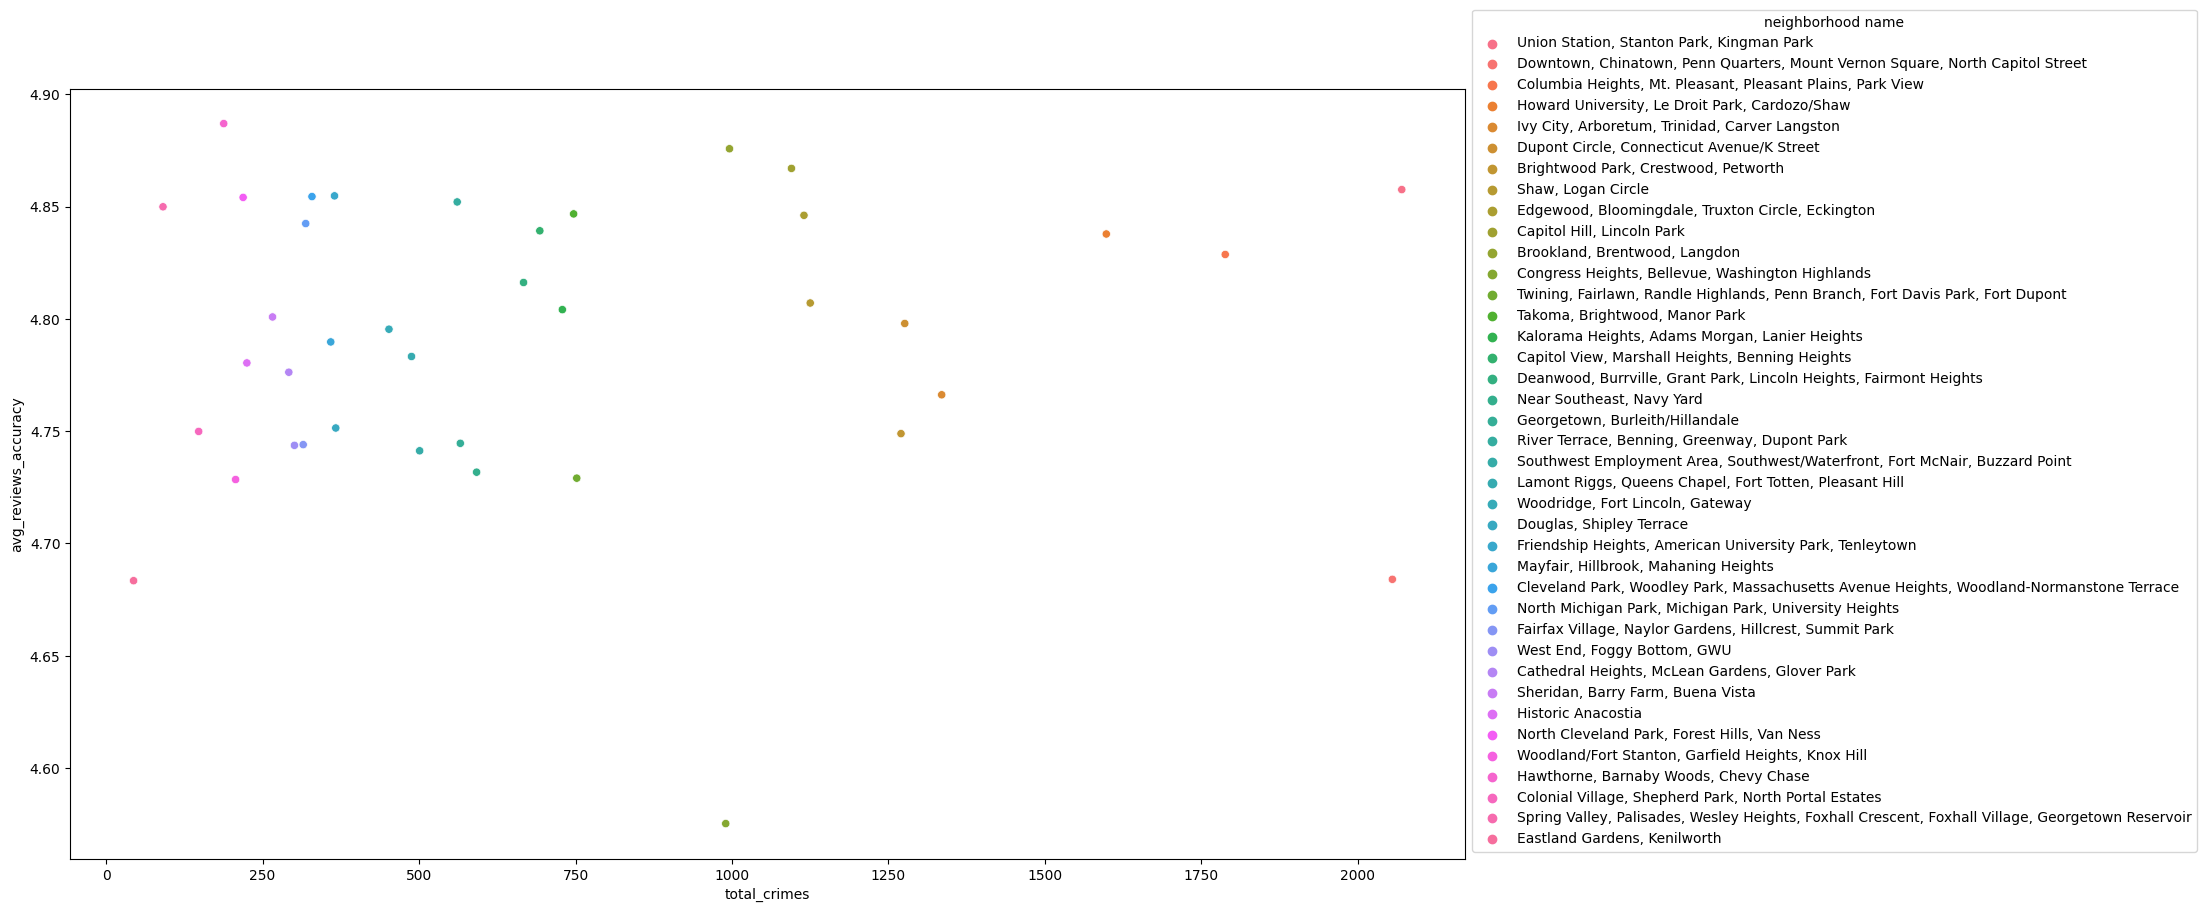

In [113]:
accuracy_review = con.execute("""
select neighbourhood_cleansed as neighborhood, avg(review_scores_accuracy) as avg_reviews_accuracy
from all_listings 
group by neighbourhood_cleansed
order by avg_reviews_accuracy desc;
""").df()

crime_review = pd.merge(crime_results, accuracy_review, on='neighborhood')

figure = plt.figure(figsize=(18, 10))
sns.scatterplot(x=crime_review.total_crimes, 
y=crime_review.avg_reviews_accuracy, 
hue=crime_review.neighborhood)
plt.legend(bbox_to_anchor=(1, 0),loc="lower left", title="neighborhood name")

For the accuracy review score, we found that there is no strong relationship. The dots are fairly discrete on the graph.

We still didn't see a strong relationship between them. 

Now let's take a look at the total reviews. Total reviews represents the number of reviews the listing has. Let's if there is a relationship between the total review and the total crimes for each neighborhood.

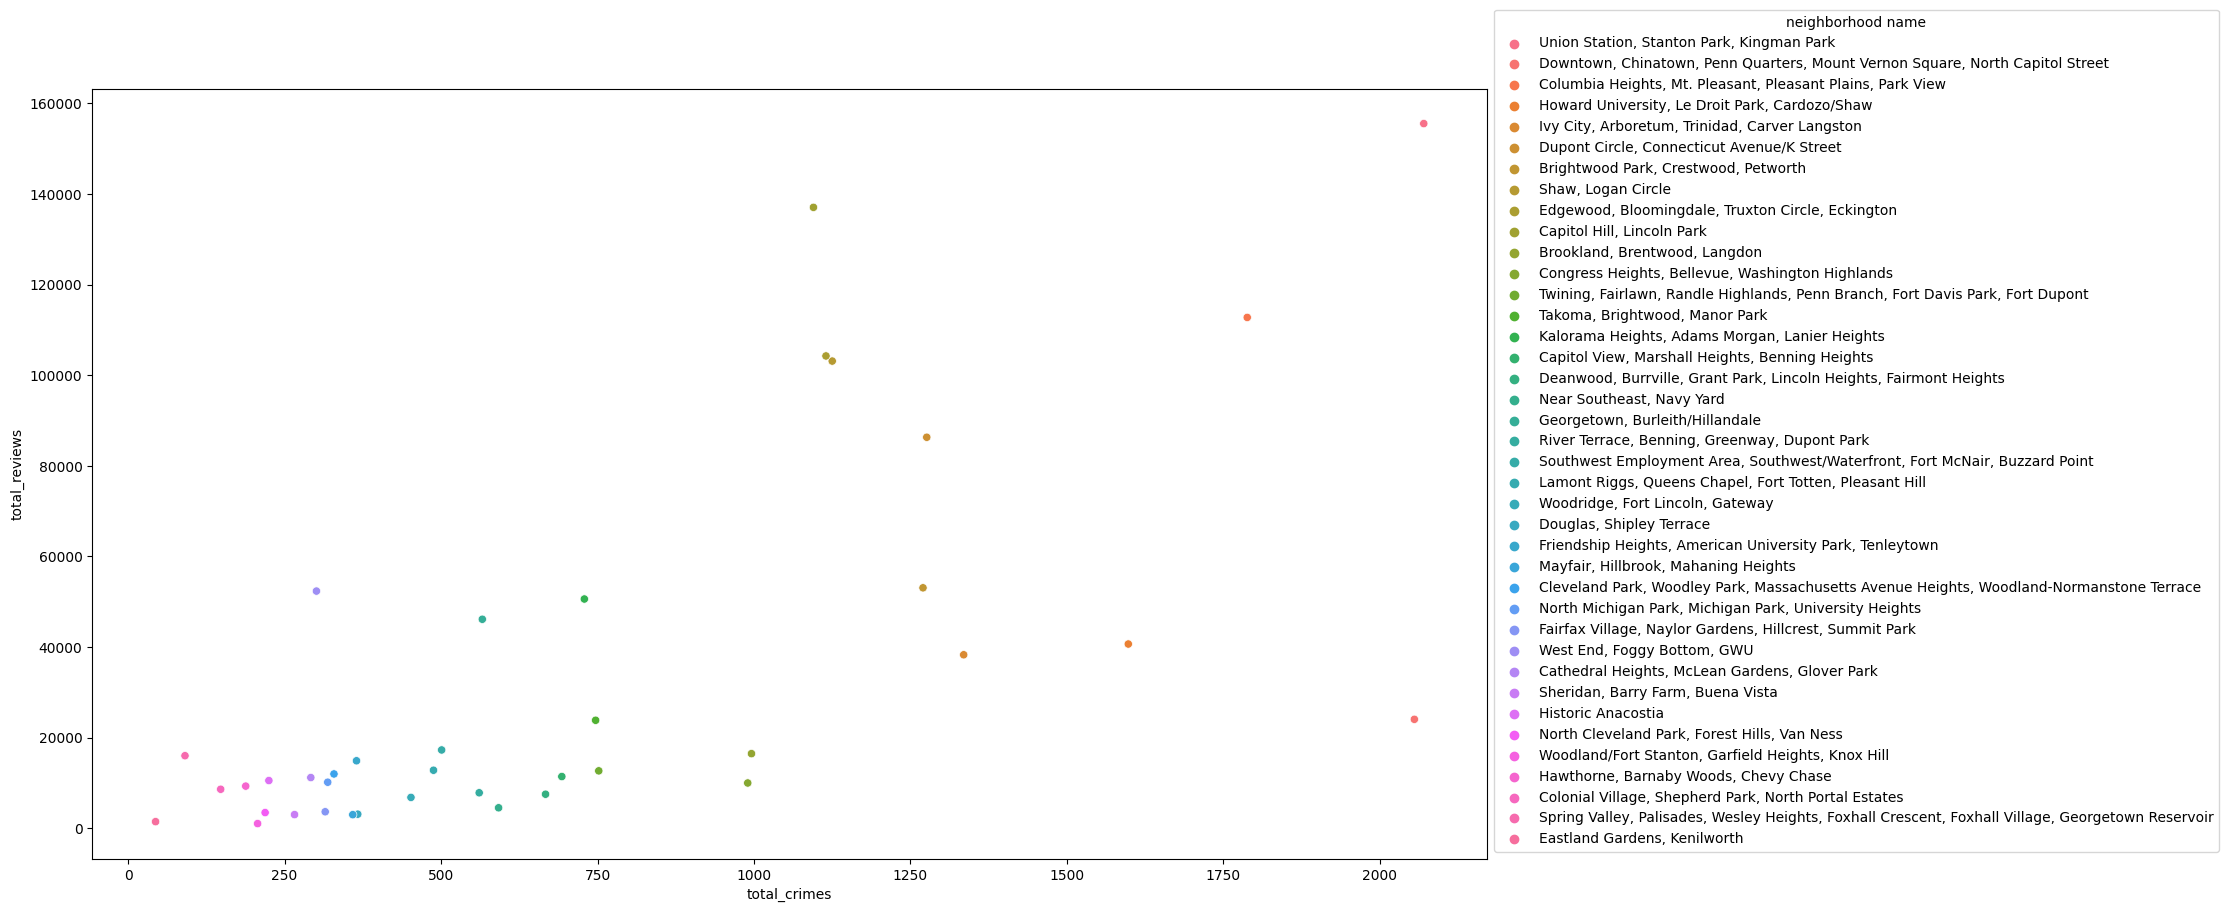

In [104]:
review_sum = con.execute("""
select neighbourhood_cleansed as neighborhood, sum(number_of_reviews) as total_reviews from all_listings 
group by neighbourhood_cleansed
order by total_reviews desc;
""").df()

crime_review = pd.merge(crime_results, review_sum, on='neighborhood')

figure = plt.figure(figsize=(18, 10))
sns.scatterplot(x=crime_review.total_crimes, 
y=crime_review.total_reviews, 
hue=crime_review.neighborhood)
plt.legend(bbox_to_anchor=(1, 0),loc="lower left", title="neighborhood name")

In this graph, we saw a very interesting up trending. It seems like the airbnb listings located in the neighborhood with more crimes will receive more reviews from the tenants. It maybe because there are more tenents choose to stay in those areas. 

Let's see if this aligned well with the reviews per month variable.

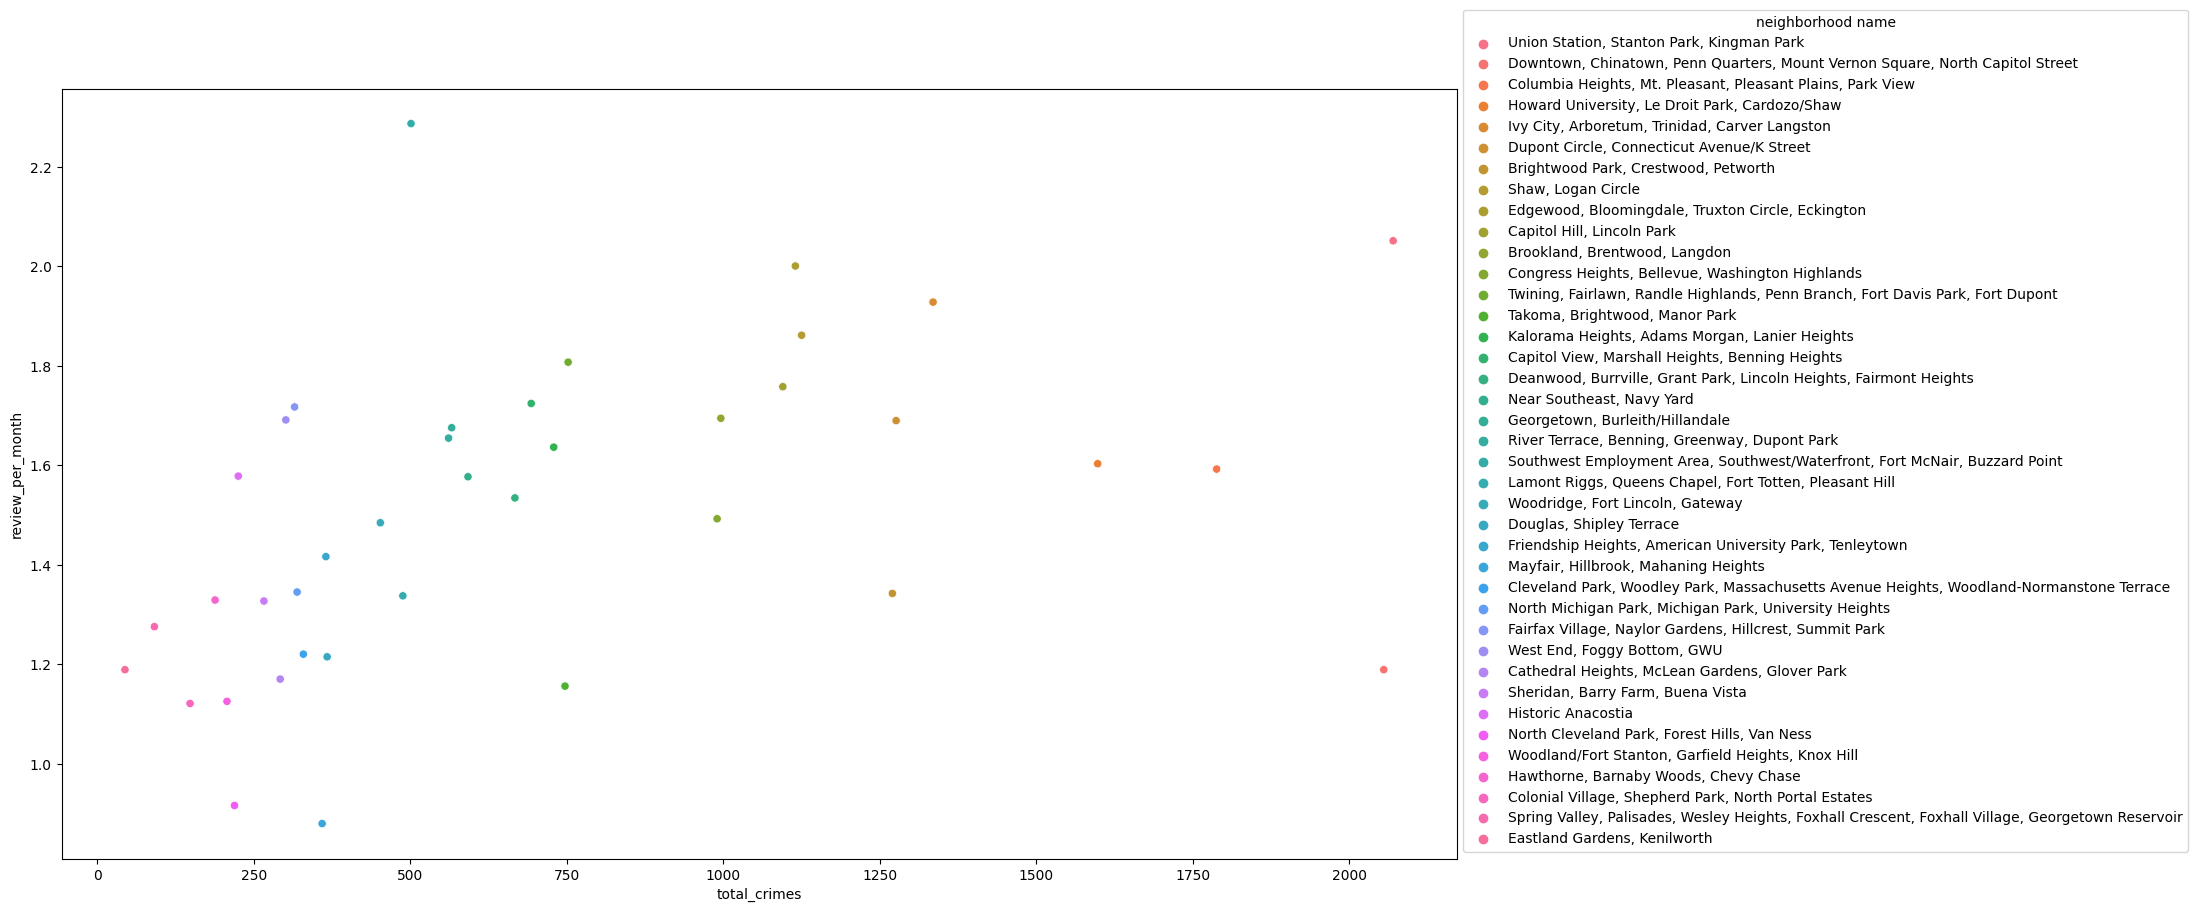

In [107]:
review_per_month = con.execute("""
select neighbourhood_cleansed as neighborhood, avg(reviews_per_month) as review_per_month from all_listings 
group by neighbourhood_cleansed
order by review_per_month desc;
""").df()

crime_review = pd.merge(crime_results, review_per_month, on='neighborhood')

figure = plt.figure(figsize=(18, 10))
sns.scatterplot(x=crime_review.total_crimes, 
y=crime_review.review_per_month, 
hue=crime_review.neighborhood)
plt.legend(bbox_to_anchor=(1, 0),loc="lower left", title="neighborhood name")

We can still see this trending similarly with reviews received per month for each listing. It seems like the listings in those ares which has more crimes will have more reviews received.